In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
bank =  pd.read_csv('bank.csv', sep=';')

In [4]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [5]:
thebank = bank.copy()

In [6]:
traincopy = bank.copy()

### RESAMPLE 'YES' TO BE SAME NUMBER AS 'NO'

In [7]:
from sklearn.utils import resample

In [8]:
# create a variable yes and no to keep the target(yes and no)
no = traincopy[traincopy['y'] == 'no']
yes = traincopy[traincopy['y'] == 'yes']

In [9]:
# resample to get equal number of yes and no
upscaledYes = resample(yes, replace=True, n_samples=len(no), random_state=42)

In [10]:
# concatenate the no and the new yes
bank = pd.concat([no, upscaledYes])

In [11]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [12]:
bank.shape

(8000, 17)

In [13]:
bank['y'].value_counts()

yes    4000
no     4000
Name: y, dtype: int64

In [14]:
# test_train_split

# GET A TEST SET

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(bank, bank['y']):
    train = bank.loc[train_index]
    test = bank.loc[test_index]



C:\Users\Iyanu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
C:\Users\Iyanu\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


In [16]:
train['y'].value_counts()

yes    3217
no     3185
Name: y, dtype: int64

In [17]:
test['y'].value_counts()

no     815
yes    783
Name: y, dtype: int64

# CREATING PIPELINE

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import Imputer

##### gets a dataframe with the selected attributes

In [19]:

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        try:
            return X[self.attribute_names]
        except KeyError:
            return X


#### returns a dataframe

In [20]:
class ReturnDataframe(BaseEstimator, TransformerMixin):
    def __init__(self, attrib):
        self.attributes = attrib
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        try:
            return pd.DataFrame(X, columns=self.attributes)
        except KeyError:
            return X

#### gets the one hot encoding of the dataframe and returns the np.array

In [21]:
class OneHotEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.get_dummies(X)

#### drop the attributes from dataframe

In [22]:

class DropDataframeColumn(BaseEstimator, TransformerMixin):
    def __init__(self, attrib):
        self.attributes = attrib
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        try:
            return X.drop(self.attributes, axis=1)
        except KeyError:
            return X

##### This works like change function which converts 'yes or no' to '1 or 0'

In [23]:

class ChangeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, attrib):
        self.attributes = attrib
    def fit(self, X, y=None):
        return self
    
    # Try to reduce the order of growth
    def transform(self, X):
        total = []
        i = 0
        try:
            for value in X.loc[:, self.attributes]:
                new = []
                for val in X[value]:
                    if val == 'yes':
                        new.append(1)
                    elif val == 'no':
                        new.append(0)
                    else:
                        break
                total.append(new)
                if [] not in total:
                    X[self.attributes[i]] = total[i]
                i += 1
            return X
        except KeyError:
            return X

In [24]:

class MonthColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        new = []
        try:
            for val in X.loc[:, 'month']:
                if val in ['jan', 'feb', 'mar', 'apr']:
                    new.append('firstpart')
                elif val in ['may', 'jun', 'jul', 'aug']:
                    new.append('secondpart')
                elif val in ['sep', 'oct', 'nov', 'dec']:
                    new.append('thirdpart')
                else:
                    pass
            X['month'] = new
            return X
        except ValueError:
            return X

In [25]:
num_attrib = ['campaign', 'housing', 'pdays', 'age', 'duration', 'day', 'balance']

In [26]:
cat_attrib = ['job', 'marital', 'month']

In [27]:
drop_attrib = ['job_entrepreneur', 'job_housemaid', 'job_student', 'job_unemployed', 'job_self-employed', 'job_retired', 'month_thirdpart'] 

In [28]:
tochange = ['housing']

In [29]:
bank['y'].value_counts()

yes    4000
no     4000
Name: y, dtype: int64

In [30]:
newbank = train.copy()

In [31]:
newbank = newbank.dropna(how='all')

In [32]:
num_pipeline = Pipeline([
 ('selector', DataFrameSelector(num_attrib)),
 ('features', ChangeFeatures(tochange)),
 ('imputer', SimpleImputer(strategy='median')),
 ('std_scaler', StandardScaler()),
 ('new_selector', ReturnDataframe(num_attrib))

])

In [33]:
cat_pipeline = Pipeline([
 ('month', MonthColumn()),
 ('selector', DataFrameSelector(cat_attrib)),
 ('imputer', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
 ('new_selector', ReturnDataframe(cat_attrib)),
 ('cat_encoder', OneHotEncoder()),
 ('drop_selector', DropDataframeColumn(drop_attrib))
])

In [34]:
output_pipeline = Pipeline([
 ('change', ChangeFeatures(['y'])),
 ('selector', DataFrameSelector(['y']))
])

In [35]:
full_pipeline = FeatureUnion(transformer_list=[
 ("num_pipeline", num_pipeline),
 ("cat_pipeline", cat_pipeline),
 ])

In [36]:
num_pipeline.fit_transform(newbank).columns

C:\Users\Iyanu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index(['campaign', 'housing', 'pdays', 'age', 'duration', 'day', 'balance'], dtype='object')

In [37]:
cat_pipeline.fit_transform(newbank).columns

Index(['job_admin.', 'job_blue-collar', 'job_management', 'job_services',
       'job_technician', 'marital_divorced', 'marital_married',
       'marital_single', 'month_firstpart', 'month_secondpart'],
      dtype='object')

In [38]:
col_name = ['job_admin.', 'job_blue-collar', 'job_management', 'job_services',
       'job_technician', 'marital_divorced', 'marital_married',
       'marital_single', 'month_firstpart', 'month_secondpart'] + ['campaign', 'housing', 'pdays', 'age', 'duration', 'day', 'balance']

In [39]:
len(col_name)

17

In [40]:
X = full_pipeline.fit_transform(newbank)

C:\Users\Iyanu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
y = output_pipeline.fit_transform(newbank)

In [42]:
X.shape

(6402, 17)

In [43]:
y.shape

(6402, 1)

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [45]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [46]:
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

In [47]:
dtc.fit(X, y)
rfc.fit(X, y)

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Iyanu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# VALIDATION

In [48]:
score_forest = cross_val_score(rfc, X, y, cv=3, scoring="accuracy")

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [49]:
print(score_forest)
print('RFC MEAN: ', score_forest.mean())

[0.64637002 0.58997188 0.60759494]
RFC MEAN:  0.6146456146381271


In [50]:
score_tree = cross_val_score(dtc, X, y, cv=3, scoring="accuracy")

In [51]:
print(score_tree)
print('DTC MEAN: ', score_tree.mean())

[0.66978923 0.60871603 0.64463197]
DTC MEAN:  0.6410457423846578


In [52]:
y_pred_forest = cross_val_predict(rfc, X, y, cv=3)

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:850: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:850: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:850: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [53]:
y_pred_tree = cross_val_predict(dtc, X, y, cv=3)

In [54]:
def my_model(ytrue, ypred):
    print(confusion_matrix(ytrue, ypred))
    print('precision: ', precision_score(ytrue, ypred))
    print("recall:", recall_score(ytrue, ypred))
    print("f1 score:", f1_score(ytrue, ypred))

In [55]:
my_model(y, y_pred_forest)

[[3056  129]
 [2468  749]]
precision:  0.8530751708428246
recall: 0.23282561392601803
f1 score: 0.3658119658119658


In [56]:
my_model(y, y_pred_tree)

[[2932  253]
 [2017 1200]]
precision:  0.8258774948382657
recall: 0.3730183400683867
f1 score: 0.5139186295503212


In [57]:
sorted(zip(col_name, dtc.feature_importances_), reverse=True)

[('pdays', 0.007590334784099912),
 ('month_secondpart', 0.014501537867475933),
 ('month_firstpart', 0.01474801410805033),
 ('marital_single', 0.002937713429427474),
 ('marital_married', 0.08577824970778677),
 ('marital_divorced', 0.1208736618983669),
 ('job_technician', 0.4219918054052642),
 ('job_services', 0.10805644779830666),
 ('job_management', 0.07367007412507137),
 ('job_blue-collar', 0.026932700039392344),
 ('job_admin.', 0.026109223615886048),
 ('housing', 0.009230340581414209),
 ('duration', 0.005024855106159848),
 ('day', 0.010451976691596882),
 ('campaign', 0.004555721719134256),
 ('balance', 0.05705905380331674),
 ('age', 0.010488289319250157)]

In [58]:
sorted(zip(col_name, rfc.feature_importances_), reverse=True)

[('pdays', 0.007861061090906313),
 ('month_secondpart', 0.01370275833907473),
 ('month_firstpart', 0.013261686847528039),
 ('marital_single', 0.008997515985742456),
 ('marital_married', 0.11746693548130735),
 ('marital_divorced', 0.09984260037435506),
 ('job_technician', 0.4039973510857445),
 ('job_services', 0.10762628446168714),
 ('job_management', 0.07681748935736203),
 ('job_blue-collar', 0.02585712763589698),
 ('job_admin.', 0.044332928688572346),
 ('housing', 0.010980256288023097),
 ('duration', 0.00934512748007462),
 ('day', 0.019540662420281785),
 ('campaign', 0.005535368683753582),
 ('balance', 0.024049663230593158),
 ('age', 0.010785182549096732)]

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [60]:
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()

In [61]:
knn.fit(X, y)
log_reg.fit(X, y)

C:\Users\Iyanu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [62]:
y_pred_reg = cross_val_predict(log_reg, X, y, cv=3)
y_pred_knn = cross_val_predict(knn, X, y, cv=3)

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\linear_

In [63]:
my_model(y, y_pred_reg)

[[2567  618]
 [ 719 2498]]
precision:  0.8016688061617459
recall: 0.7764998445756917
f1 score: 0.7888836254539713


In [64]:
my_model(y, y_pred_knn)

[[2681  504]
 [1415 1802]]
precision:  0.7814397224631396
recall: 0.5601492073360274
f1 score: 0.652543907296759


# PRECISION/RECALL CURVE

In [64]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

### for random forest

In [65]:
y_pred_forest = cross_val_predict(rfc, X, y, cv=3, method='predict_proba')

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

In [67]:
y_scores_forest = y_pred_forest[:, 1]

In [68]:
precisions, recalls, thresholds = precision_recall_curve(y, y_scores_forest)

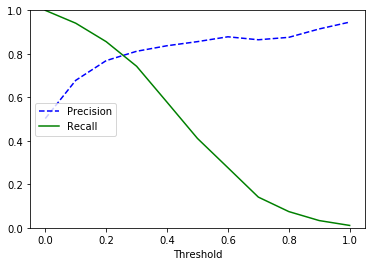

In [69]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

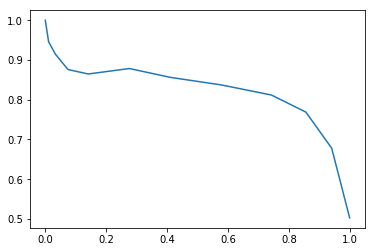

In [70]:
plt.plot(recalls, precisions)

In [71]:
y_pred_90 = (y_scores_forest > 0.1) #or 0.2

In [72]:
precision_score(y, y_pred_90)

0.7688442211055276

In [73]:
recall_score(y, y_pred_90)

0.8560770904569475

### for decision tree

In [74]:
y_pred_tree = cross_val_predict(dtc, X, y, cv=3, method='predict_proba')

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [75]:
y_scores_tree = y_pred_tree[:, 1]

In [76]:
precisions, recalls, thresholds = precision_recall_curve(y, y_scores_tree)

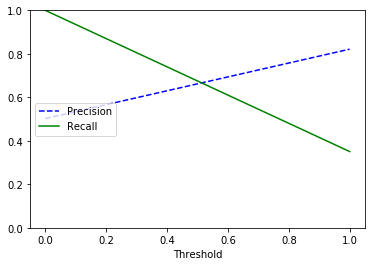

In [77]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

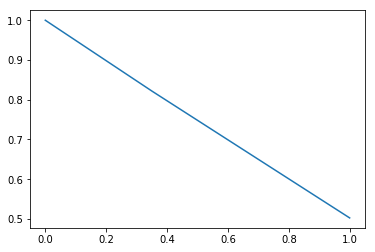

In [78]:
plt.plot(recalls, precisions)

In [79]:
y_pred_90 = (y_scores_tree > 0.2) #consstant for all values

In [80]:
precision_score(y, y_pred_90)

0.8215586307356154

In [81]:
recall_score(y, y_pred_90)

0.3506372396642835

### FOR KNN

In [82]:
y_probas_knn = cross_val_predict(knn, X, y, cv=3, 
                                 method="predict_proba")

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [83]:
y_scores_knn = y_probas_knn[:, 1] 

In [84]:
precisions, recalls, thresholds = precision_recall_curve(y, y_scores_knn)

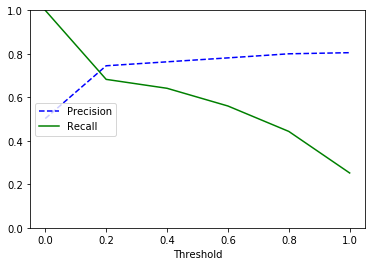

In [85]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

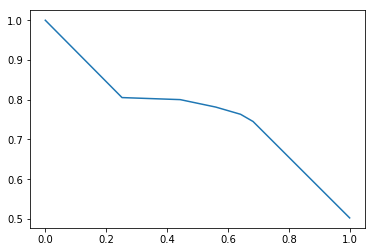

In [86]:
plt.plot(recalls, precisions)

In [87]:
y_pred_90 = (y_scores_knn > 0.1) #or 0.2


In [88]:
precision_score(y, y_pred_90)

0.7451645741431965

In [89]:
recall_score(y, y_pred_90)

0.6826235623251476

### for LOG REG

In [90]:
y_probas_reg = cross_val_predict(log_reg, X, y, cv=3, 
                                 method="predict_proba")

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [91]:
y_scores_reg = y_probas_reg[:, 1] 

In [92]:
precisions, recalls, thresholds = precision_recall_curve(y, y_scores_reg)

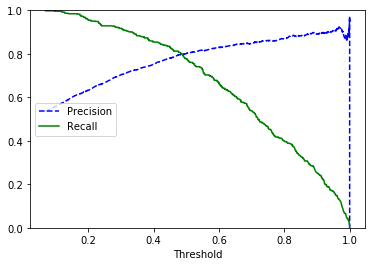

In [93]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

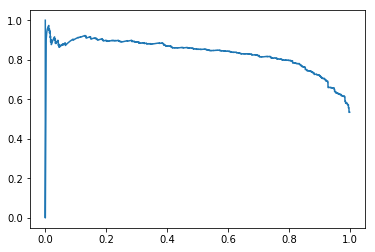

In [94]:
plt.plot(recalls, precisions)

In [95]:
y_pred_90 = (y_scores_reg > 0.4) #or 0.3

In [96]:
precision_score(y, y_pred_90)

0.7518467852257182

In [97]:
recall_score(y, y_pred_90)

0.8542119987566056

# ROC CURVE

### for random forest

In [98]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y,y_scores_forest)


# for KNN

In [99]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y,y_scores_knn)


# For LOG-REG

In [100]:
fpr_reg, tpr_reg, thresholds_reg = roc_curve(y,y_scores_reg)


### for decision tree 

In [101]:
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y,y_scores_tree)


In [102]:
def plot_roc_curve(fpr, tpr, label=None):
     plt.plot(fpr, tpr, linewidth=2, label=label)
     plt.plot([0, 1], [0, 1], 'k--')
     plt.axis([0, 1, 0, 1])
     plt.xlabel('False Positive Rate')
     plt.ylabel('True Positive Rate')


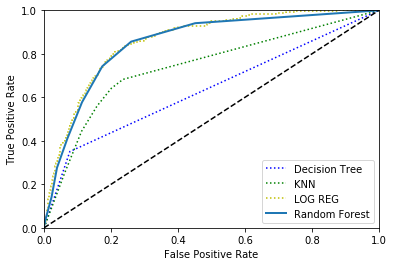

In [103]:
plt.plot(fpr_tree, tpr_tree, "b:", label="Decision Tree")
plt.plot(fpr_knn, tpr_knn, "g:", label="KNN")
plt.plot(fpr_reg, tpr_reg, "y:", label="LOG REG")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [104]:
roc_auc_score(y, y_scores_tree)

0.6368570813706033

In [105]:
roc_auc_score(y, y_scores_forest)

0.8505841953241925

In [106]:
roc_auc_score(y, y_scores_knn)

0.7402051210479649

In [107]:
roc_auc_score(y, y_scores_reg)

0.8607227401134768

# TUNING

In [130]:
from sklearn.model_selection import GridSearchCV

# for forest

In [132]:
param_grid_forest = [
 {'n_estimators': [3, 10, 30], 'max_features': [10, 12, 14, 15]},
 {'bootstrap': [False], 'n_estimators': [3, 10, 20], 'max_features': [10, 12, 14, 15]},
 ]

In [134]:
grid_search_forest = GridSearchCV(rfc, param_grid_forest, cv=5,
 scoring='accuracy')

In [135]:
grid_search_forest.fit(X, y)

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y wa

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y wa

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y wa

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y wa

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y wa

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [10, 12, 14, 15]}, {'bootstrap': [False], 'n_estimators': [3, 10, 20], 'max_features': [10, 12, 14, 15]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [136]:
grid_search_forest.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# for log-reg

In [140]:
log_reg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [153]:
param_grid_reg = [
 {'fit_intercept': [False], 'penalty': ['l1','l2']},
 {'fit_intercept': [False], 'dual': [True], 'multi_class': ['ovr']},
 {'solver': ['newton-cg', 'lbfgs'], 'dual': [False], 'multi_class': ['ovr']}
]

In [154]:
grid_search_reg = GridSearchCV(log_reg, param_grid_reg, cv=5,
 scoring='accuracy')

In [155]:
grid_search_reg.fit(X, y)

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\linear_

C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Iyanu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'fit_intercept': [False], 'penalty': ['l1', 'l2']}, {'fit_intercept': [False], 'dual': [True], 'multi_class': ['ovr']}, {'solver': ['newton-cg', 'lbfgs'], 'dual': [False], 'multi_class': ['ovr']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [156]:
grid_search_reg.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [67]:
def test_result(true_test, prediction):
    print(confusion_matrix(true_test, prediction))
    print('ACCURACY SCORE: ', accuracy_score(true_test, prediction))
    print('PRECISION: ', precision_score(true_test, prediction))
    print('RECALL: ', recall_score(true_test, prediction))

# TEST 2

In [65]:
mytest = pd.read_csv('bank_test.csv')

In [66]:
mytest['y'].value_counts()

no     801
yes    104
Name: y, dtype: int64

In [69]:
X_test = full_pipeline.fit_transform(mytest)
y_test = output_pipeline.fit_transform(mytest)

C:\Users\Iyanu\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
pred = dtc.predict(X_test)
pred1 = rfc.predict(X_test)
pred2 = knn.predict(X_test)
pred3 = log_reg.predict(X_test)

# pred4 = grid_search_forest.predict(X_test)
# pred5 = grid_search_reg.predict(X_test)

In [71]:
test_result(y_test, pred)

[[697 104]
 [ 39  65]]
ACCURACY SCORE:  0.8419889502762431
PRECISION:  0.38461538461538464
RECALL:  0.625


In [72]:
test_result(y_test, pred1)

[[738  63]
 [ 34  70]]
ACCURACY SCORE:  0.8928176795580111
PRECISION:  0.5263157894736842
RECALL:  0.6730769230769231


In [73]:
test_result(y_test, pred2)

[[646 155]
 [  7  97]]
ACCURACY SCORE:  0.8209944751381215
PRECISION:  0.38492063492063494
RECALL:  0.9326923076923077


In [74]:
test_result(y_test, pred3)

[[522 279]
 [  9  95]]
ACCURACY SCORE:  0.6817679558011049
PRECISION:  0.2540106951871658
RECALL:  0.9134615384615384
